# **Chapter 4 다양한 분류 알고리즘**

## **04-1 로지스틱 회귀**

### 1) 럭키백의 확률

"럭키백"? :

    생선이름이 없는 생선 선물세트
    내용물은 7가지 생선 중 하나
    선물세트에는 7가지 생선의 확률만 표시

생선이 든 선물세트 '럭키백'을 이용한 교재의 설명이 모호하다. 공부할 내용은 target의 범주가 둘이 아니고 여럿일 경우, 범주별 확률을 구해서 분류하는 방법이다. 즉 **다중분류(multi-class classification)**를 공부한다.

**이름(7가지 중 하나)을 모르는 생선이 있다. 길이, 무게, 높이, 대각선, 두께 등을 보고 생선 이름마다 확률을 구하자. 그 7개 확률을 보고 그 중 가장 확률이 높은 이름으로 분류하면 되겠다.**

#### a) 데이터 준비하기

분석할 생선 데이터는 5개의 feature 변수와 생선의 종류(Species)가 들어있는 159개 데이터다. 아래와 같이 `read_csv()` 함수로 불러 데이터프레임으로 만들자.

In [ ]:
import pandas as pd
import numpy as np

fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


데이터에 어떤 생선 종류가 있는지 알아보려면 `pd.unique()` 이용.

In [ ]:
pd.unique(fish['Species'])

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

 몇 마리씩 들어있는지 알아보려면 `pd.value_counts()` 이용.

In [ ]:
pd.value_counts(fish['Species'])

<ipython-input-4-9368debc1958>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(fish['Species'])


,count
Species,
Perch,56
Bream,35
Roach,20
Pike,17
Smelt,14
Parkki,11
Whitefish,6


생선의 빈도가 많은 것부터 출력되었다. 정렬을 하지 않고 데이터에 있는 순서대로 출력하려면,

In [ ]:
pd.value_counts(fish['Species'], sort = False)

<ipython-input-5-710d9cafb8f2>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(fish['Species'], sort = False)


,count
Species,
Bream,35
Roach,20
Whitefish,6
Parkki,11
Perch,56
Pike,17
Smelt,14


우리는 데이터프레임 `fish`에 있는 6개 변수 가운데 `Species`를 target으로, 나머지 다섯 변수를 feature 변수로 이용할 것이다.

feature 변수만 골라내는 방법은 여럿이다.

In [ ]:
fish.iloc[:,1:6]

,Weight,Length,Diagonal,Height,Width
0,242.0,25.4,30.0,11.5200,4.0200
1,290.0,26.3,31.2,12.4800,4.3056
2,340.0,26.5,31.1,12.3778,4.6961
3,363.0,29.0,33.5,12.7300,4.4555
4,430.0,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...
154,12.2,12.2,13.4,2.0904,1.3936
155,13.4,12.4,13.5,2.4300,1.2690
156,12.2,13.0,13.8,2.2770,1.2558
157,19.7,14.3,15.2,2.8728,2.0672


In [ ]:
fish.iloc[:,0]

,Species
0,Bream
1,Bream
2,Bream
3,Bream
4,Bream
...,...
154,Smelt
155,Smelt
156,Smelt
157,Smelt


다시 생선 데이터 분류 문제로 돌아가자.

먼저 `to_numpy()`를 이용해서 feature와 target 배열을 만들고 `train_test_split()`을 이용해서 train, test dataset을 만들자.

In [ ]:
data=fish.iloc[:,1:6].to_numpy()
target=fish.iloc[:,0].to_numpy()

print(data[:5],target[:5])

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]] ['Bream' 'Bream' 'Bream' 'Bream' 'Bream']


In [ ]:
print(data.shape, target.shape)

(159, 5) (159,)


In [ ]:
from sklearn.model_selection import train_test_split

train,test,target1,target2=train_test_split(data,target,random_state=0,stratify=target)

변수들을 표준화하기 위해 `StandardScaler()`를 이용해서 train 데이터에 `fit()`을 적용하고 train, test 데이터를 변환하자.

In [ ]:
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
strain=ss.fit_transform(train)
stest=ss.transform(test)

#### b) k-최근접 이웃 분류기의 확률 예측

먼저 knn 분류방법을 이용해보자. 범주가 둘일 때와 똑같다. 여기서 k = 3으로 두자.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

m=KNeighborsClassifier(n_neighbors=3)
m.fit(strain,target1)

print(m.score(strain,target1))
print(m.score(stest,target2))

0.907563025210084
0.725


test data의 처음 5 개 target 값과 분류결과는 다음과 같다.

In [ ]:
print(target2[:5])

['Bream' 'Bream' 'Perch' 'Perch' 'Bream']


In [ ]:
print(m.predict(stest[:5]))

['Parkki' 'Bream' 'Perch' 'Perch' 'Bream']


knn은 어떻게 분류했을까? 40개 test data 각각에 대해 가장 가까운 데이터 3개를 보고 각 생선이름의 확률을 구해서 분류한다. 확률값들을 보려면 `predict_proba()` 이용.

In [ ]:
import numpy as np

p = m.predict_proba(stest[:5])
print(np.round(p, decimals=4))

[[0.3333 0.6667 0.     0.     0.     0.     0.    ]
 [1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.    ]
 [1.     0.     0.     0.     0.     0.     0.    ]]


데이터에서 가장 가까운 3개의 target 값은 아래와 같이 확인할 수 있다.

In [ ]:
d, i = m.kneighbors(stest[[0]])
target1[i]

array([['Parkki', 'Parkki', 'Bream']], dtype=object)

즉 knn은 주변에 'Perch'가 가장 많으므로 첫번째 데이터를 'Parkki'로 분류한 것이다.

이 방법의 문제점 가운데 하나는 k = 3이라고 할 때 나올 수 있는 확률들의 값이 0, 1/3, 2/3, 1 넷밖에 없다는 점이다. 확률이 원래 0부터 1 사이의 모든 실수값을 다 가질 수 있어야한다는 점을 생각해보면 knn은 한계가 뚜렷한 방법이다.

### 2) 로지스틱 회귀

##### a) 로지스틱 함수

183쪽의 회귀 방정식을 보자. 다섯 개 feature 변수를 이용해서 생선의 종류를 예측하고 싶다. 그러기 위해서는 각 생선으로 분류할 확률을 구해야한다.

로지스틱 회귀는 선형회귀와 마찬가지로 교재 183쪽의 식처럼 feature변수들마다 회귀계수(가중치)를 추정해서 등호 왼편의 `z` 값을 구한다. 그런데 이런 값은 0보다 작거나 1보다 클 수 있으므로 확률의 추정값으로 쓸 수 없다. 이럴 때 로지스틱함수를 이용하면 `z`를 0과 1 사이의 값으로 변환할 수 있다.

로지스틱회귀는 이름은 '회귀'지만 target 변수의 범주마다 확률을 구한 다음 그 확률이 가장 큰 범주로 데이터를 분류하는 분류 알고리즘이다.

0과 1사이의 범위에서 확률을 구하는 데 널리 쓰이는 함수가 logistic function이다. 아래 그림처럼 S자 모양으로 생긴 함수로서 sigmoid function이라고도 부른다. 이 함수의 역함수는 로짓함수(logit function)다.

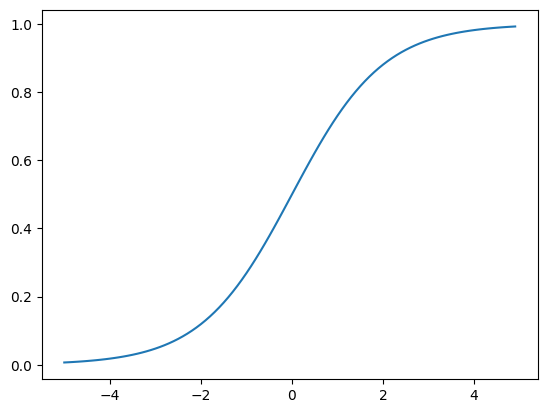

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

z=np.arange(-5,5,0.1)
p=1/(1+np.exp(-z))

plt.plot(z,p)
plt.show()

교재의 기호를 따르면 $x$가 feature 변수이고 $Y$가 0 아니면 1 값을 갖는 target 변수라고 할 때

$$z = \alpha + \beta x $$

라고 하면,

\begin{align} p &= {\rm P}(Y=1) \\ &= \frac{1} {1 + e^{-z} } \\ &= \frac {1}{1+e^{-(\alpha + \beta x) }} .\end{align}

따라서 $z, p~$의 관계는 다음과 같다.

$$z = \log(\frac{p}{1-p}) = \alpha + \beta x .$$

이진 분류를 위한 로지스틱회귀에서는 데이터로부터 회귀계수($\alpha, \beta$)들을 추정하여 $z$를 구한 다음, $P(Y=1), ~P(Y=0)$을 계산한다.

0과 1 두 범주 중에서 큰 확률을 갖는 값이 $Y$의 예측값이 된다.

#### b) 로지스틱 회귀로 이진 분류 수행하기

119개 train_scaled와 train_target 데이터에서 도미와 빙어 데이터만 골라보자.

In [ ]:
i = (target1 == 'Bream') | (target1 == 'Smelt')
strain = strain[i]
target1 = target1[i]

* 퀴즈 : `train_bream_smelt, target_bream_smelt`에 도미와 빙어 데이터가 모두 들어있는가?



In [ ]:
l, c = np.unique(target1, return_counts = True)
print(l, c)

['Bream' 'Smelt'] [26 10]


로지스틱 회귀를 위한 `LogisticRegression` 클래스는 사이킷런의 `linear_model` 모듈 안에 있다. `fit, predict` 등의 함수를 이용하는 절차는 knn 분류와 마찬가지다.

In [ ]:
from sklearn.linear_model import LogisticRegression

m=LogisticRegression()
m.fit(strain,target1)

print(m.score(strain,target1))
print(m.score(stest,target2))

1.0
0.325


첫 5개의 분류결과를 보자.

In [ ]:
m.predict(strain[:5])

array(['Bream', 'Bream', 'Bream', 'Smelt', 'Smelt'], dtype=object)

그렇게 분류한 이유를 두 범주의 확률을 비교해서 알아보자.

In [ ]:
m.predict_proba(strain[:5])

array([[0.97365556, 0.02634444],
       [0.98230176, 0.01769824],
       [0.97589388, 0.02410612],
       [0.03689586, 0.96310414],
       [0.03011565, 0.96988435]])

위의 확률 가운데 첫번째가 도미, 두번째가 빙어다.

In [ ]:
m.classes_

array(['Bream', 'Smelt'], dtype=object)

따라서 target변수의 범주 1은 빙어, 0은 도미를 나타낸다.

로지스틱 회귀 계수 추정결과는 아래와 같다.

In [ ]:
print(m.coef_, m.intercept_)

[[-0.42726508 -0.58925081 -0.66410809 -0.98107787 -0.77189061]] [-2.19791717]




* **퀴즈 : 왜 회귀 계수(가중치) `lr.coef_`의 값들이 모두 음수인가?**

`decision_function()`을 이용하면 그 계수들을 가지고 구한 `z` 값을 알 수 있다.

In [ ]:
decisions = m.decision_function(strain[:5])
decisions

array([-3.60980051, -4.01643336, -3.70088826,  3.2620621 ,  3.47213201])

* 퀴즈 : 위의 값들은 어떻게 구한 것인가?

In [ ]:
z1 = m.coef_ * strain[:5]
z1

array([[-0.02687089, -0.03307384, -0.15268632, -1.00969821, -0.18955409],
       [-0.05498642, -0.1011127 , -0.2347041 , -1.15895294, -0.26876003],
       [-0.02687089, -0.04877511, -0.17455773, -1.10066585, -0.15210151],
       [ 0.46807497,  0.90376897,  1.0283697 ,  1.56417759,  1.49558804],
       [ 0.47077406,  0.97180784,  1.11038747,  1.61884858,  1.49823123]])

`z1`의 각 행에 있는 다섯 개 값을 모두 합하고 절편 값을 더하면 되겠다.

In [ ]:
z2 = np.sum(z1, axis = 1) + m.intercept_
z2

array([-3.60980051, -4.01643336, -3.70088826,  3.2620621 ,  3.47213201])

각 `z`값에서 구한 로지스틱함수 값

$$ \frac {1}{1 + e^{-z} } $$

을 보려면 사이파이 패키지의 `special` 모듈에 있는 `expit` 함수를 이용하면 된다([도움말](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html)).

아래 출력은 처음 다섯개 데이터에서 target의 범주가 1(빙어, Smelt)이 될 확률을 구한 것이다.

In [ ]:
from scipy.special import expit

expit(decisions)

array([0.02634444, 0.01769824, 0.02410612, 0.96310414, 0.96988435])

* 퀴즈 : 위의 값들은 어떻게 계산된 것인가?

In [ ]:
1/(1+np.exp(-z2))

array([0.02634444, 0.01769824, 0.02410612, 0.96310414, 0.96988435])

#### c) 로지스틱 회귀로 다중 분류 수행하기

로지스틱회귀를 이용한 다중분류를 공부하기 전에 `LogisticRegression()`의 괄호 속에 들어갈 수 있는 parameter들에 대해 살펴보자.

먼저 로지스틱회귀는 적절한 값을 찾을 때까지 여러 번 반복 계산이 필요한 방법이다. 반복 횟수가 너무 적으면 필요한 계산을 다 마무리하지 못할 수 있고 너무 많으면 시간이 오래 걸린다. `max_iter`로 이 횟수를 지정할 수 있다.

또한 선형회귀에서 공부한 리지, 랏소와 같이 로지스틱회귀에서도 회귀계수들을 규제할 수 있는데 이때 `C`라는 파라미터를 이용한다. 기본값은 1이고 이 값을 크게 정하면 규제가 약해진다.

이제 일곱가지 생선이 다 들어있는 데이터를 분류해보자. 훈련데이터는 `train_scaled, train_taget`이고 훈련데이터의 수는 119개다.

In [ ]:
from sklearn.model_selection import train_test_split

train,test,target1,target2=train_test_split(data,target,random_state=0,stratify=target)

In [ ]:
from sklearn.preprocessing import StandardScaler

ss=StandardScaler()
strain=ss.fit_transform(train)
stest=ss.transform(test)



일단 교재를 따라 `max_iter = 100, C = 20`으로 두자.

In [ ]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression(C = 20, max_iter = 1000)
m.fit(strain, target1)

print(m.score(strain, target1))
print(m.score(stest, target2))

0.9327731092436975
0.85


처음 다섯 개 test 데이터에 대해 분류 결과와 확률을 알아보자.

In [ ]:
m.predict(stest[:5])

array(['Parkki', 'Bream', 'Perch', 'Perch', 'Bream'], dtype=object)

In [ ]:
p = m.predict_proba(stest[:5])
np.round(p, decimals=3)

array([[0.414, 0.517, 0.   , 0.   , 0.034, 0.   , 0.034],
       [0.977, 0.015, 0.   , 0.   , 0.   , 0.   , 0.008],
       [0.   , 0.008, 0.856, 0.   , 0.128, 0.   , 0.008],
       [0.   , 0.005, 0.774, 0.001, 0.206, 0.   , 0.014],
       [0.805, 0.042, 0.   , 0.   , 0.01 , 0.   , 0.143]])

In [ ]:
m.classes_

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

이진 분류와 달리 **다중 분류에서는 target의 범주마다 `z`값을 구한다. 따라서 범주가 7개면 회귀계수도 7번 구한다.**

In [ ]:
print(m.coef_.shape, m.intercept_.shape)

(7, 5) (7,)


데이터마다 이제 7개의 `z`값을 구했고 이로부터 softmax 함수를 이용해서 7개의 확률을 구한다. softmax 함수에 대해서는 교재 190-191쪽 설명 참조.

In [ ]:
decision = m.decision_function(stest[:5])
np.round(decision, decimals=2)

array([[  5.83,   6.05,  -3.51,  -2.29,   3.33, -12.73,   3.33],
       [ 10.55,   6.38,  -3.79,  -0.71,   1.83, -19.93,   5.68],
       [ -6.31,   1.26,   5.94,  -3.88,   4.04,  -2.28,   1.24],
       [ -4.8 ,   0.38,   5.38,  -1.56,   4.06,  -4.82,   1.36],
       [  7.28,   4.31,  -0.76,  -1.11,   2.89, -18.15,   5.55]])

softmax 함수는 사이파이의 `special` 모듈 안에 있으며, 확률을 계산할 방향을 행단위(`axis = 1`) 또는 열단위(`axis = 0`) 등으로 지정해야 한다.

In [ ]:
from scipy.special import softmax

p = softmax(decision, axis=1)
np.round(p, decimals=3)

array([[0.414, 0.517, 0.   , 0.   , 0.034, 0.   , 0.034],
       [0.977, 0.015, 0.   , 0.   , 0.   , 0.   , 0.008],
       [0.   , 0.008, 0.856, 0.   , 0.128, 0.   , 0.008],
       [0.   , 0.005, 0.774, 0.001, 0.206, 0.   , 0.014],
       [0.805, 0.042, 0.   , 0.   , 0.01 , 0.   , 0.143]])